In [1]:
import numpy as np
from netCDF4 import Dataset
from scipy.stats import pearsonr
import datetime
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime
import seaborn as sns
import os
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import CS2_CPOM radar freeboard, air temperature and wind speed data from 01/01/2010 - 31/12/2020
all_fbs = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])
temp = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/ERA5_temp.nc')['Temperature'])
wind = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/ERA5_windspeed.nc')['Wind Speed'])

days = np.arange(0,4018)

### calculate regional smoothed anomalies

In [3]:
# function to calculate regional means 
def regions_WG(regs):
    WG_mean = []
    WG_c = all_interps.copy()
    for day in days:
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in days:
        WG_mean.append(np.nanmean(WG_c[day]))
    return(WG_mean)

# function to calculate running mean, where T = np.int(number of days/2)
def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T]))

    for i in range(np.size(means)-T,np.size(means)):
        r.append(np.nanmean(means[i-T:]))

    return r

In [4]:
mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')

regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

T = 15 # 31-day running mean
fb_anoms = {} ; temp_anoms = {} ; wind_anoms = {}
data = [all_fbs, temp, wind]
dics = [fb_anoms, temp_anoms, wind_anoms]

for all_interps, dic in zip(data,dics):
    for region, reg in zip(regions, regs):
        dm = regions_WG(reg)
        rm = runningmean(dm,T=15)
        dic[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))

### calculate regional correlations

In [5]:
seasons = ['2010-11','2011-12','2012-13','2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20']

dayss = [np.arange(273,485), # 2010-2011
        np.arange(638,851), # 2011-2012
        np.arange(1004,1216), # 2012-2013
        np.arange(1369,1581), # 2013-2014
        np.arange(1734,1946), # 2014-2015
        np.arange(2099,2312), # 2015-2016
        np.arange(2465,2677), # 2016-2017
        np.arange(2830,3042), # 2017-2018
        np.arange(3195,3407), # 2018-2019
        np.arange(3560,3773), # 2019-2020
       ]

def stats():
    var = varr[region][day]
    fb = fb_anoms[region][day]
    mask = ~np.isnan(fb) & ~np.isnan(var) 
    try:
        rstats = pearsonr(fb[mask],var[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        return(p,r)
    except:
        pass

In [6]:
# temperature

temp_mask = np.full((len(seasons),len(regions)),np.nan)
rs_table = np.full((len(seasons),len(regions)),np.nan)

varr = temp_anoms
for counter, region in enumerate(regions):
    for count, season in enumerate(seasons):
        day = dayss[count]
        p,r = stats()
        rs_table[count,counter] = r
        temp_mask[count,counter] = p
        
temp_corrs = pd.DataFrame(data=rs_table, index=None, columns=None)

# wind

wind_mask = np.full((len(seasons),len(regions)),np.nan)
rs_table = np.full((len(seasons),len(regions)),np.nan)

varr = wind_anoms
for counter, region in enumerate(regions):
    for count, season in enumerate(seasons):
        day = dayss[count]
        p,r = stats()
        rs_table[count,counter] = r
        wind_mask[count,counter] = p
        
wind_corrs = pd.DataFrame(data=rs_table, index=None, columns=None)

### plot figure

In [7]:
%%capture output
x = plt.imshow(np.full((3,3),np.nan),vmin=-1,vmax=1,cmap='RdBu')

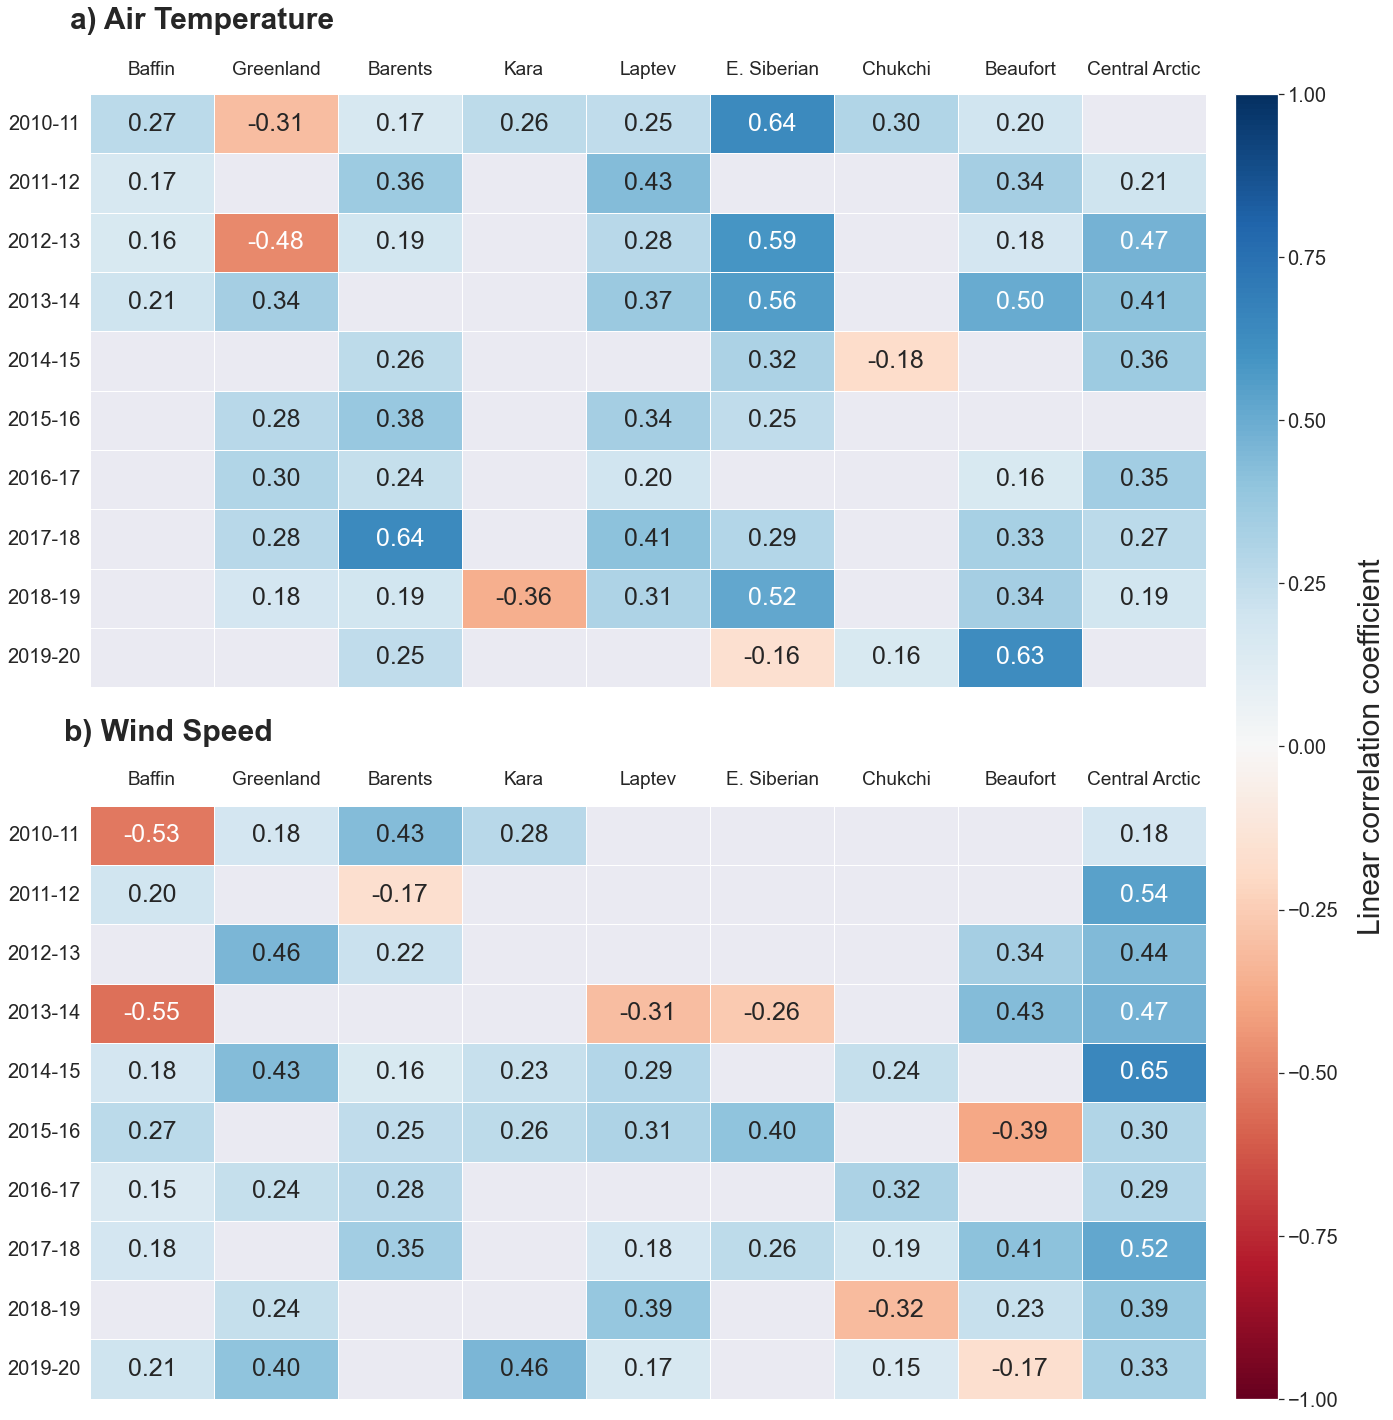

In [8]:
fig = plt.figure(figsize = (20,24))
sns.set(rc = {'figure.figsize':(20,24)})
spec = gridspec.GridSpec(ncols=1, nrows=2,
                         width_ratios=[1], wspace=0.5,
                         hspace=0.2)

# Temperature
ax1 = fig.add_subplot(spec[0])
mask = temp_mask
mask[mask>0.05] = 1000
mask[mask<1000] = 0
ax1 = sns.heatmap(temp_corrs, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":25}, cbar=None)
ax1.xaxis.tick_top()
ax1.set_xlabel(' ')    
ax1.set_yticklabels(seasons,rotation = 0,fontsize = 20)
ax1.set_xticklabels(regions,fontsize = 19, y = 1.01)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labeltop=True)
ax1.set_title('a) Air Temperature', x = 0.1,y = 1.1,fontweight="bold",fontsize = 30)

# Wind
ax2 = fig.add_subplot(spec[1])
mask = wind_mask
mask[mask>0.05] = 1000
mask[mask<1000] = 0
ax2 = sns.heatmap(wind_corrs, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":25}, cbar=None)
ax2.set_xticklabels([])
ax2.set_xlabel(' ')  
ax2.set_yticklabels(seasons,rotation = 0,fontsize = 20)
ax2.set_xticklabels(regions,fontsize = 19,y = 1.075)
ax2.set_title('b) Wind Speed', x = 0.07 ,y = 1.1,fontweight="bold",fontsize = 30)
    
cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.755])
cb = fig.colorbar(x, cax=cbar_ax)
cb.set_label("Linear correlation coefficient",fontsize= 30,labelpad=20)
cb.ax.tick_params(labelsize=20)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/wind_temp_stats.png',bbox_inches = "tight")